In [3]:
import pandas as pd

## 1. The AB-test data
<p>The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:</p>
<ul>
<li><code>userid</code> - a unique number that identifies each player.</li>
<li><code>version</code> - whether the player was put in the control group (<code>gate_30</code> - a gate at level 30) or the group with the moved gate (<code>gate_40</code> - a gate at level 40).</li>
<li><code>sum_gamerounds</code> - the number of game rounds played by the player during the first 14 days after install.</li>
<li><code>retention_1</code> - did the player come back and play <strong>1 day</strong> after installing?</li>
<li><code>retention_7</code> - did the player come back and play <strong>7 days</strong> after installing?</li>
</ul>
<p>When a player installed the game, he or she was randomly assigned to either <code>gate_30</code> or <code>gate_40</code>.</p>



In [4]:
df = pd.read_csv('./data/cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


### Sanity Check
<p>It looks like there is roughly the same number of players in each group</p>

In [5]:
df.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


## 2. The distribution of game rounds
<p>In the plot below we can see that some players install the game but then never play it (0 game rounds), some players just play a couple of game rounds in their first week, and some get really hooked!</p>

Text(0, 0.5, 'Total rounds')

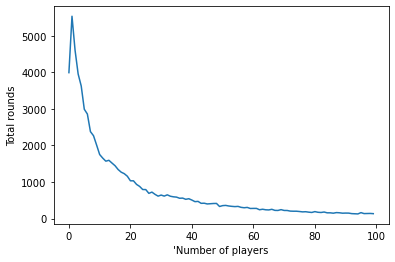

In [6]:
%matplotlib inline

plot_df = df.groupby('sum_gamerounds')['userid'].count()

ax = plot_df.head(100).plot(x='sum_gamerounds', y='userid')
ax.set_xlabel("'Number of players")
ax.set_ylabel("Total rounds")

## 3. Overall 1-day retention
<p>What we want is for players to like the game and to get hooked. A common metric in the video gaming industry for how fun and engaging a game is <em>1-day retention</em>: The percentage of players that comes back and plays the game <em>one day</em> after they have installed it.  The higher 1-day retention is, the easier it is to retain players and build a large player base. </p>

In [7]:
df['retention_1'].sum()/df['retention_1'].count()

0.4452095044850259

<p>A little less than half of the players come back one day after installing the game.</p>

### 1-day retention by AB-group


In [8]:
df.groupby('version')['retention_1'].sum()/df.groupby('version')['retention_1'].count()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

<p>It appears that there was a slight decrease in 1-day retention when the gate was moved to level 40 (44.2%) compared to the control when it was at level 30 (44.8%). It's a small change, but even small changes in retention can have a large impact.</p>
<p>To get at the certainty of these retention numbers, we can repeatedly re-sample our dataset (with replacement) and calculate 1-day retention for those samples. The variation in 1-day retention will give us an indication of how uncertain the retention numbers are.</p>

<AxesSubplot:ylabel='Density'>

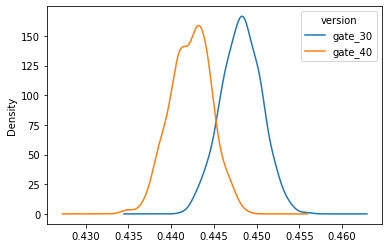

In [9]:
boot_1d = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
boot_1d = pd.DataFrame(boot_1d)
boot_1d.plot.density()

<p>These two distributions above represent the bootstrap uncertainty over what the underlying 1-day retention could be for the two AB-groups. Just eyeballing this plot, we can see that there seems to be some evidence of a difference, albeit small.</p>

### Zooming in on the difference
<p>From the below chart, we can see that the most likely % difference is around 1% - 2%, and that most of the distribution is above 0%, in favor of a gate at level 30.</p>

Text(0.5, 0, '% Difference in 1-day Retention')

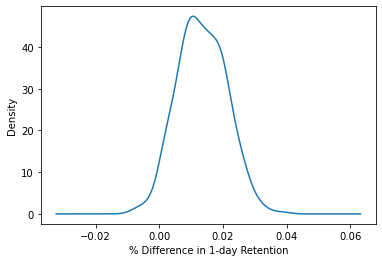

In [10]:
boot_1d['diff'] = (boot_1d['gate_30'] - boot_1d['gate_40'])/boot_1d['gate_40']

ax = boot_1d['diff'].plot.density()
ax.set_xlabel('% Difference in 1-day Retention')

There is a high probability that 1-day retention is better when the gate is at level 30. 

In [11]:
prob = (boot_1d['diff'] > 0).sum()/len(boot_1d)
print(prob)

0.974


## 4. 7-day retention
<p>Since players have only been playing the game for one day, it is likely that most players haven't reached level 30 yet. That is, many players won't have been affected by the gate, even if it's as early as level 30. </p>
<p>But after having played for a week, more players should have reached level 40, and therefore it makes sense to also look at 7-day retention. That is: What percentage of the people that installed the game also showed up a week later to play the game again.</p>

<p>Like with 1-day retention, we see that 7-day retention is slightly lower (18.2%) when the gate is at level 40 than when the gate is at level 30 (19.0%). This difference is also larger than for 1-day retention, presumably because more players have had time to hit the first gate. We also see that the <em>overall</em> 7-day retention is lower than the <em>overall</em> 1-day retention; fewer people play a game a week after installing than a day after installing.</p>

In [12]:
df.groupby('version')['retention_7'].sum()/df.groupby('version')['retention_7'].count()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

There is strong evidence that 7-day retention is higher when the gate is at level 30 than when it is at level 40. 

1.0


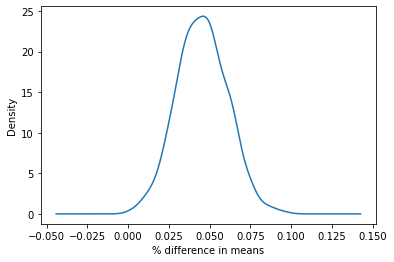

In [13]:
boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
boot_7d = pd.DataFrame(boot_7d)

boot_7d['diff'] = (boot_7d['gate_30'] - boot_7d['gate_40'])/boot_7d['gate_40']

ax = boot_7d['diff'].plot.density()
ax.set_xlabel("% difference in means")

prob = (boot_7d['diff'] > 0).sum()/len(boot_7d)
print(prob)

<p>The conclusion is: If we want to keep retention high — both 1-day and 7-day retention — we should <strong>not</strong> move the gate from level 30 to level 40. There are, of course, other metrics we could look at, like the number of game rounds played or how much in-game purchases are made by the two AB-groups. But retention <em>is</em> one of the most important metrics. If we don't retain our player base, it doesn't matter how much money they spend in-game.</p>
<p><img src="https://assets.datacamp.com/production/project_184/img/cookie_yellow.png" style="width:100px; float:center"> </p>
<p>So, why is retention higher when the gate is positioned earlier? One could expect the opposite: The later the obstacle, the longer people are going to engage with the game. But this is not what the data tells us. The theory of <em>hedonic adaptation</em> can give one explanation for this. In short, hedonic adaptation is the tendency for people to get less and less enjoyment out of a fun activity over time if that activity is undertaken continuously. By forcing players to take a break when they reach a gate, their enjoyment of the game is prolonged. But when the gate is moved to level 40, fewer players make it far enough, and they are more likely to quit the game because they simply got bored of it. </p>